In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from netCDF4 import Dataset
import pandas as pd
import properscoring as ps
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import warnings
import xarray as xr
from global_land_mask import globe
# from matplotlib import cm
from utils.evaluation import find_landfalling_tcs,tc_region,create_xarray,get_storm_coords
# from utils.metrics import calculate_crps
# from global_land_mask import globe
# from scipy.interpolate import griddata
from multiprocessing import Pool
# from utils.metrics import calculate_fid
import xesmf as xe
warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))
sns.set_palette(sns.color_palette("Set2"))

In [2]:
def plot_accumulated(data,lats,lons,vmin=0,vmax=200,plot='show',cmap='Blues',title='Accumulated Rainfall',levels=[0,50,100,150,200,250,300],centre_lats=None,centre_lons=None,intensity=None):
        """
        Plots the accumulated rainfall of a tropical cyclone while it's at tropical cyclone strength
        """
        data = np.where(data<10,np.nan,data)
        lat2d,lon2d = np.meshgrid(lats,lons)
        fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
        c = ax.contourf(lon2d,lat2d,data,vmin=vmin,vmax=vmax,levels=levels,cmap = cmap, transform=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
        if centre_lats is not None:
                for i in range(len(centre_lats)):
                        if intensity[i] == 0.0:
                                colour = '#ffb600'
                        elif intensity[i] == 1.0:
                                colour =  '#ff9e00'
                        elif intensity[i] == 2.0:
                                colour = '#ff7900'
                        elif intensity[i] == 3.0:       
                                colour = '#ff6000'
                        elif intensity[i] == 4.0:
                                colour = '#ff4000' 
                        elif intensity[i]==5.0:
                                colour = '#ff2000' 
                        ax.plot(centre_lons[i:i+2],centre_lats[i:i+2],color=colour)

        ax.outline_patch.set_linewidth(0.5)
        cbar = plt.colorbar(c, shrink=0.68)
        cbar.ax.tick_params(labelsize=6,width=0.5)

        if plot=='show':
                plt.show()
        else:
                plt.savefig('figs/basin_rainfall.png',bbox_inches='tight',dpi=300)

In [3]:
def find_basin_coords(basin):
	# grab mswep coordinate variables
	fp = '/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
	ds = xr.open_dataset(fp)
	if basin == 'NA':
		min_lon,min_lat,max_lon,max_lat = -100,5,-30,30
	elif basin == 'NIO':
		min_lon,min_lat,max_lon,max_lat = 40,5,110,30
	elif basin == 'NWP':
			min_lon,min_lat,max_lon,max_lat = 90,5,179,30
	elif basin == 'SPO':
			min_lon,min_lat,max_lon,max_lat = 130,-30,-110,-5
	elif basin == 'A':
			min_lon,min_lat,max_lon,max_lat = 70,-30,150,-5

	mask_lon = (ds.lon >= min_lon) & (ds.lon <= max_lon)
	mask_lat = (ds.lat >= min_lat) & (ds.lat <= max_lat)
	cropped_ds = ds.where(mask_lon & mask_lat, drop=True)

	lats = cropped_ds.lat.values
	lons = cropped_ds.lon.values
	return lats,lons


In [4]:
def find_basin_tcs(meta,basin):
		"""
		Grabs all tcs that ever make landfall at tc strength

				inputs : meta csv
		"""
		nstorms,_ = meta.shape
		basin_sids = []
		if basin == 'NA':
			min_lon,min_lat,max_lon,max_lat = -100,5,-30,30
		elif basin == 'NIO':
			min_lon,min_lat,max_lon,max_lat = 40,5,110,30
		elif basin == 'NWP':
			min_lon,min_lat,max_lon,max_lat = 90,5,179,30
		elif basin == 'SPO':
			min_lon,min_lat,max_lon,max_lat = 130,-30,-110,-5
		elif basin == 'A':
			min_lon,min_lat,max_lon,max_lat = 70,-30,150,-5
		
		for i in range(nstorms):
				centre_lat = meta['centre_lat'][i]
				centre_lon = meta['centre_lon'][i]
				if centre_lon > 180:
						centre_lon = centre_lon - 180
				in_basin = (centre_lat >= min_lat) & (centre_lat <= max_lat) & (centre_lon >= min_lon) & (centre_lon <= max_lon)
				if in_basin:
						sid = meta['sid'][i]
						basin_sids.append(sid)

		# find indices of all basining snapshots
		basin_sids = list(dict.fromkeys(basin_sids))
		return basin_sids

In [5]:
mode = 'validation'
real = np.load('/user/home/al18709/work/dsrnngan_predictions/%s_real-opt.npy' % mode)[0][:,:,:,0]
pred = np.load('/user/home/al18709/work/dsrnngan_predictions/%s_pred-opt.npy' % mode)[0][:,:,:,0]
inputs = np.load('/user/home/al18709/work/dsrnngan_predictions/%s_input-opt.npy' % mode)[0][:,:,:,0]
meta = pd.read_csv('/user/work/al18709/tc_data_mswep/valid_meta.csv')
tcs = pd.read_csv('/user/work/al18709/ibtracks/tc_files.csv')
print(meta['centre_lon'])

0       -54.8000
1       -54.9000
2       -50.9000
3       -48.4000
4       -53.1651
          ...   
16248    67.2658
16249    66.7858
16250    64.6074
16251    63.2224
16252    63.0066
Name: centre_lon, Length: 16253, dtype: float64


In [6]:
# define basin
basin = 'NA'
lats,lons = find_basin_coords(basin)

basin_sids = find_basin_tcs(meta,basin)
# assign sid variable to list of sid indices correspoinnding to storm timesteps
for sid in basin_sids:
	indices = meta.sid[meta.sid == sid].index.tolist()
	exec('sid_%s = indices' % sid)

all_sids = list(dict.fromkeys(meta['sid']))
print(basin_sids)
print(len(basin_sids))
print(len(all_sids))




['1986254N22309', '1996319N11283', '1981307N17279', '2010169N13266', '1989230N14338', '2018300N25315', '2001245N13326', '2006237N13298', '2000273N16277', '2005186N12299', '1999236N22292', '1989286N19268', '2005245N19315', '1989254N13340', '1988242N13262', '2018280N18273', '2015270N27291', '2014259N11262', '2003269N12322', '2012246N29323', '2010279N22293', '1985240N20286', '1984189N11265', '2001255N26276', '1983141N07269', '2006254N20306', '2017260N12310', '2011199N10271', '2017280N32321', '1992230N11325', '1992185N13265', '1982257N20291', '1993241N14264', '1998264N10343', '2010263N15328', '1988285N09318', '2011233N15301', '2007225N12331', '2005249N26281', '1992297N26299', '1989212N23270', '2005232N13263', '2004264N13328', '1996233N12340', '1991268N12264', '2005275N19274', '2005192N11318', '2020205N26272', '2005138N10265', '1994306N23313', '1995212N22287', '2008241N19303', '2016242N24279', '1995281N14278', '1995235N13311', '1995241N11333', '1984267N31302', '2020291N32305', '2011250N1232

In [7]:


# accumulated = np.zeros(grid_x.shape)
# for sid in basin_sids:
# 	print(sid)
def computation(sid):
	# initialise accumulated xarray
	grid_x, grid_y = np.meshgrid(lats, lons)
	a = np.zeros((grid_x.shape))
	accumulated_ds = create_xarray(lats,lons,a)
	accumulated_ds_pred = create_xarray(lats,lons,a)
	accumulated_ds_input = create_xarray(lats,lons,a)

	# grab mswep coordinate variables
	fp = '/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
	d = Dataset(fp, 'r')
	lat = d.variables['lat'][:] #lat
	lon = d.variables['lon'][:] #lon
	sid = str(sid[0])
	# print('sid',sid)
	for i in globals()['sid_%s' % sid]:
		# print('i is',i)
		
		storm_lats,storm_lons = get_storm_coords(lat,lon,meta,i)
		ds = create_xarray(storm_lats,storm_lons,real[i])
		ds_pred = create_xarray(storm_lats,storm_lons,pred[i])
		input_lats,input_lons = get_storm_coords(np.arange(-89.5,90,1),np.arange(-179.5,180),meta,i)
		if input_lons.shape == (100,):
			print(sid)
			print('inputs shape',inputs[i].shape)
			continue
		ds_input = create_xarray(input_lats,input_lons,inputs[i])

		# regrid so grids match
		# regridder = xe.Regridder(ds, accumulated_ds, "nearest_s2d")
		regridder = xe.Regridder(ds, accumulated_ds, "bilinear")
		ds_out = regridder(ds)
		ds_pred_out = regridder(ds_pred)
		

		# regird the inputs
		regridder = xe.Regridder(ds_input, accumulated_ds, "bilinear")
		ds_input_out = regridder(ds_input)

		# add up rainfall
		accumulated_ds = accumulated_ds + ds_out
		accumulated_ds_pred = accumulated_ds_pred + ds_pred_out
		accumulated_ds_input = accumulated_ds_input + ds_input_out
		# print('sum',np.sum(accumulated_ds.precipitation.values))
		return accumulated_ds,accumulated_ds_pred,accumulated_ds_input

def process(df):
	# print('doing process...')
	res = df.apply(computation,axis=1)
	return res

if __name__ == '__main__':
	df = pd.DataFrame(basin_sids)
	df_split = np.array_split(df, len(basin_sids))
	p = Pool(processes=len(basin_sids))
	# print('pooling processes...')

	pool_results = p.map(process, df_split)
	print('results pooled')
	# result = sum(p)
	p.close()

	p.join()

results pooled


In [8]:
# print(accumulated_ds)
# print(accumulated_ds_input)
# print(accumulated_ds_pred)
grid_x, grid_y = np.meshgrid(lats, lons)
a = np.zeros((grid_x.shape))
accumulated_ds = create_xarray(lats,lons,a)
accumulated_ds_pred = create_xarray(lats,lons,a)
accumulated_ds_input = create_xarray(lats,lons,a)
print(len(pool_results))
print(len(pool_results[2][2]))
print(len(pool_results[0][0]))
print(len(pool_results[0][0][0]))

for i in range(len(pool_results)):
	if pool_results[i][i] == None:
		continue
	accumulated_ds = accumulated_ds + pool_results[i][i][0]
	accumulated_ds_pred = accumulated_ds_pred + pool_results[i][i][1]
	accumulated_ds_input = accumulated_ds_input + pool_results[i][i][2]

print(accumulated_ds)

59
3
3
1
<xarray.Dataset>
Dimensions:        (x: 700, y: 250)
Coordinates:
    lon            (x) float32 -99.95 -99.85 -99.75 ... -30.25 -30.15 -30.05
    lat            (y) float32 5.05 5.15 5.25 5.35 ... 29.65 29.75 29.85 29.95
Dimensions without coordinates: x, y
Data variables:
    precipitation  (x, y) float64 2.688 2.625 2.75 2.75 ... 0.0 0.0 0.0 0.0


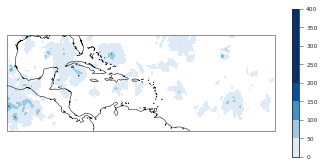

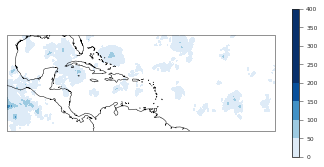

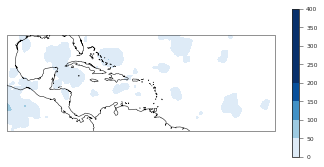

In [9]:
levels = [0,50,100,150,200,250,300,350,400]
centre_lats=None
centre_lons = None
intensity = None
# TODO: add tracklines for storms
plot_accumulated(accumulated_ds['precipitation'],accumulated_ds['lat'].values,accumulated_ds['lon'].values,vmin=0,vmax=200,levels = levels,plot='save',centre_lats=centre_lats,centre_lons=centre_lons,intensity=intensity)
plot_accumulated(accumulated_ds_pred['precipitation'],accumulated_ds_pred['lat'].values,accumulated_ds_pred['lon'].values,vmin=0,vmax=200,levels = levels,plot='save',centre_lats=centre_lats,centre_lons=centre_lons,intensity=intensity)
plot_accumulated(accumulated_ds_input['precipitation'],accumulated_ds_input['lat'].values,accumulated_ds_input['lon'].values,vmin=0,vmax=200,levels = levels,plot='save',centre_lats=centre_lats,centre_lons=centre_lons,intensity=intensity)



obs total: 1082167.3125
predicted total: 921882.3874233456
LR total: 857261.6145091224
pred_error:  160284.9250766544
obs_error:  224905.69799087755


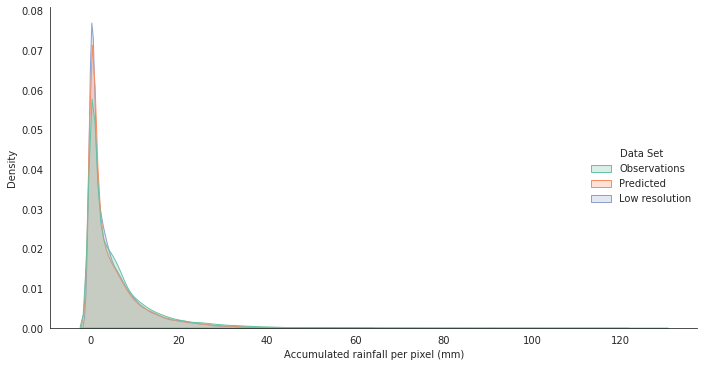

In [12]:
# accumulated_ds = accumulated_ds.where(accumulated_ds > 1)
# accumulated_ds_pred = accumulated_ds_pred.where(accumulated_ds_pred > 1)
# accumulated_ds_input = accumulated_ds_input.where(accumulated_ds_input > 1)
# print(globe.is_land(grid_x, grid_y))
# # plt.contourf(grid_x,grid_y,globe.is_ocean(grid_x, grid_y))
# plot_accumulated(globe.is_land(grid_x, grid_y),accumulated_ds['lat'].values,accumulated_ds['lon'].values,vmin=0,vmax=2,levels = [0,1,2],plot='save',centre_lats=centre_lats,centre_lons=centre_lons,intensity=intensity)
# plt.show()
# plt.clf()

# accumulated_ds = accumulated_ds.where(globe.is_land(grid_x, grid_y))
# accumulated_ds_pred = accumulated_ds_pred.where(globe.is_land(grid_x, grid_y))
# accumulated_ds_input = accumulated_ds_input.where(globe.is_land(grid_x, grid_y))

rain = pd.DataFrame({
	'Observations':accumulated_ds.precipitation.values.flatten(),
	'Predicted':accumulated_ds_pred.precipitation.values.flatten(),
	'Low resolution':accumulated_ds_input.precipitation.values.flatten(),

})
p = sns.displot(rain,kind="kde",fill='true',height=5, aspect=10/5)
p.set(xlabel='Accumulated rainfall per pixel (mm)')
sns.move_legend(p, "upper right", bbox_to_anchor=(.85, .6), title='Data Set')
plt.savefig('figs/accumulated_hist_basin.png',bbox_inches='tight')
# point_lat,point_lon = -82.3666, 23.1136

# TODO: subsample first and second half of valid set
# TODO: power spectra

print('obs total:',np.sum(rain['Observations']))
print('predicted total:',np.sum(rain['Predicted']))
print('LR total:',np.sum(rain['Low resolution']))

print('pred_error: ', np.sum(rain['Observations']) - np.sum(rain['Predicted']))
print('obs_error: ', np.sum(rain['Observations']) - np.sum(rain['Low resolution']))